<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: Modeling Predictiion Dengue Cases in Singapore

### Import libary

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

from sklearn.linear_model import LinearRegression, Lasso , Ridge
from sklearn.model_selection import train_test_split

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import itertools
#import warnings
import matplotlib.pyplot as plt

Load Data

In [2]:
df = pd.read_csv('../data/weekly_data.csv')

In [3]:
df.head()

,Unnamed: 0,total_rainfall,mean_temperature,minimum_temperature,maximum_temperature,dengue_cases,interest,inbound,outbound
0,2012-W01,106.8,26.762500,22.2,31.4,74,8,239701,115076
1,2012-W02,25.8,26.228571,22.1,32.3,66,8,239701,115076
2,2012-W03,28.0,26.914286,22.9,32.5,61,6,239701,115076
3,2012-W04,8.6,26.600000,23.5,31.6,52,10,239701,115076
4,2012-W05,55.7,26.485714,21.5,31.6,85,7,239701,115076


In [4]:
df.tail()

,Unnamed: 0,total_rainfall,mean_temperature,minimum_temperature,maximum_temperature,dengue_cases,interest,inbound,outbound
567,2022-W48,96.8,27.057143,22.8,32.9,242,19,204085,185454
568,2022-W49,65.6,26.800000,23.9,32.7,327,27,232834,250220
569,2022-W50,81.8,26.414286,23.9,32.2,290,30,232834,250220
570,2022-W51,10.2,26.685714,23.4,31.7,270,20,232834,250220
571,2022-W52,16.0,27.100000,23.1,31.3,285,25,232834,250220


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           572 non-null    object 
 1   total_rainfall       572 non-null    float64
 2   mean_temperature     572 non-null    float64
 3   minimum_temperature  572 non-null    float64
 4   maximum_temperature  572 non-null    float64
 5   dengue_cases         572 non-null    int64  
 6   interest             572 non-null    int64  
 7   inbound              572 non-null    int64  
 8   outbound             572 non-null    int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 40.3+ KB


In [6]:
df.set_index(df['Unnamed: 0'],inplace=True)

In [7]:
df.drop(columns='Unnamed: 0')

,total_rainfall,mean_temperature,minimum_temperature,maximum_temperature,dengue_cases,interest,inbound,outbound
Unnamed: 0,,,,,,,,
2012-W01,106.8,26.762500,22.2,31.4,74,8,239701,115076
2012-W02,25.8,26.228571,22.1,32.3,66,8,239701,115076
2012-W03,28.0,26.914286,22.9,32.5,61,6,239701,115076
2012-W04,8.6,26.600000,23.5,31.6,52,10,239701,115076
2012-W05,55.7,26.485714,21.5,31.6,85,7,239701,115076
...,...,...,...,...,...,...,...,...
2022-W48,96.8,27.057143,22.8,32.9,242,19,204085,185454
2022-W49,65.6,26.800000,23.9,32.7,327,27,232834,250220
2022-W50,81.8,26.414286,23.9,32.2,290,30,232834,250220


conduct data shift as we are unbale to use current month data to predict current month dengue cases, therefor we will be using data from pervious month to train the model

In [8]:
df['mean_temperature'] = df['mean_temperature'].shift(1)
df['total_rainfall'] = df['total_rainfall'].shift(1)
df['interest'] = df['interest'].shift(1)
df['minimum_temperature'] = df['minimum_temperature'].shift(1)
df['maximum_temperature'] = df['maximum_temperature'].shift(1)
df['inbound'] = df['inbound'].shift(1)
df['outbound'] = df['outbound'].shift(1)

# Drop any rows with missing values
df.dropna(inplace=True)

In [9]:
df.head()

,Unnamed: 0,total_rainfall,mean_temperature,minimum_temperature,maximum_temperature,dengue_cases,interest,inbound,outbound
Unnamed: 0,,,,,,,,,
2012-W02,2012-W02,106.8,26.762500,22.2,31.4,66,8.0,239701.0,115076.0
2012-W03,2012-W03,25.8,26.228571,22.1,32.3,61,8.0,239701.0,115076.0
2012-W04,2012-W04,28.0,26.914286,22.9,32.5,52,6.0,239701.0,115076.0
2012-W05,2012-W05,8.6,26.600000,23.5,31.6,85,10.0,239701.0,115076.0
2012-W06,2012-W06,55.7,26.485714,21.5,31.6,87,7.0,239701.0,115076.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 571 entries, 2012-W02 to 2022-W52
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           571 non-null    object 
 1   total_rainfall       571 non-null    float64
 2   mean_temperature     571 non-null    float64
 3   minimum_temperature  571 non-null    float64
 4   maximum_temperature  571 non-null    float64
 5   dengue_cases         571 non-null    int64  
 6   interest             571 non-null    float64
 7   inbound              571 non-null    float64
 8   outbound             571 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 44.6+ KB


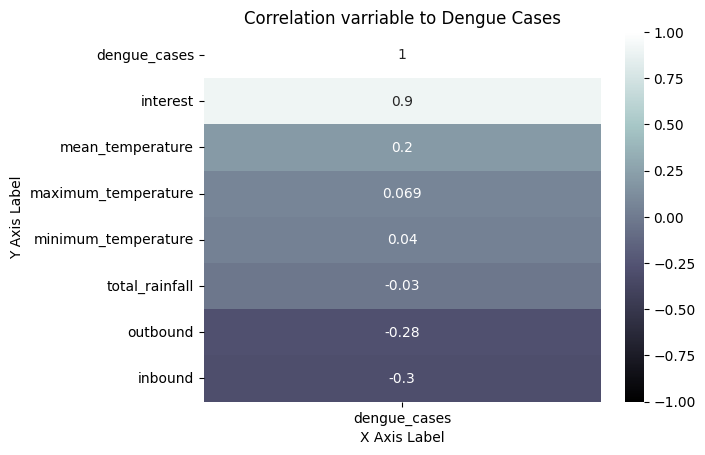

In [11]:
# Define custom y-axis tick labels
yticklabels = df['dengue_cases']

# Create a heatmap using seaborn with custom y-axis tick labels
#sns.heatmap(df.drop(columns='Unnamed: 0', inplace=False), annot=True, cmap='coolwarm', yticklabels=yticklabels)
sns.heatmap(df.corr(method='pearson',numeric_only=True)[['dengue_cases']].sort_values(by='dengue_cases', ascending=False), 
                      vmin=-1, vmax=1, annot=True, cmap='bone')

# Add labels and title
plt.xlabel('X Axis Label')
plt.ylabel('Y Axis Label')
plt.title('Correlation varriable to Dengue Cases')

# Display the heatmap
plt.show()

From this heatmap we are able to tell that variables: interest, mean temperature, inbound and outbound has some correlation to Dengue Cases 

In [12]:
#function to plot 
def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

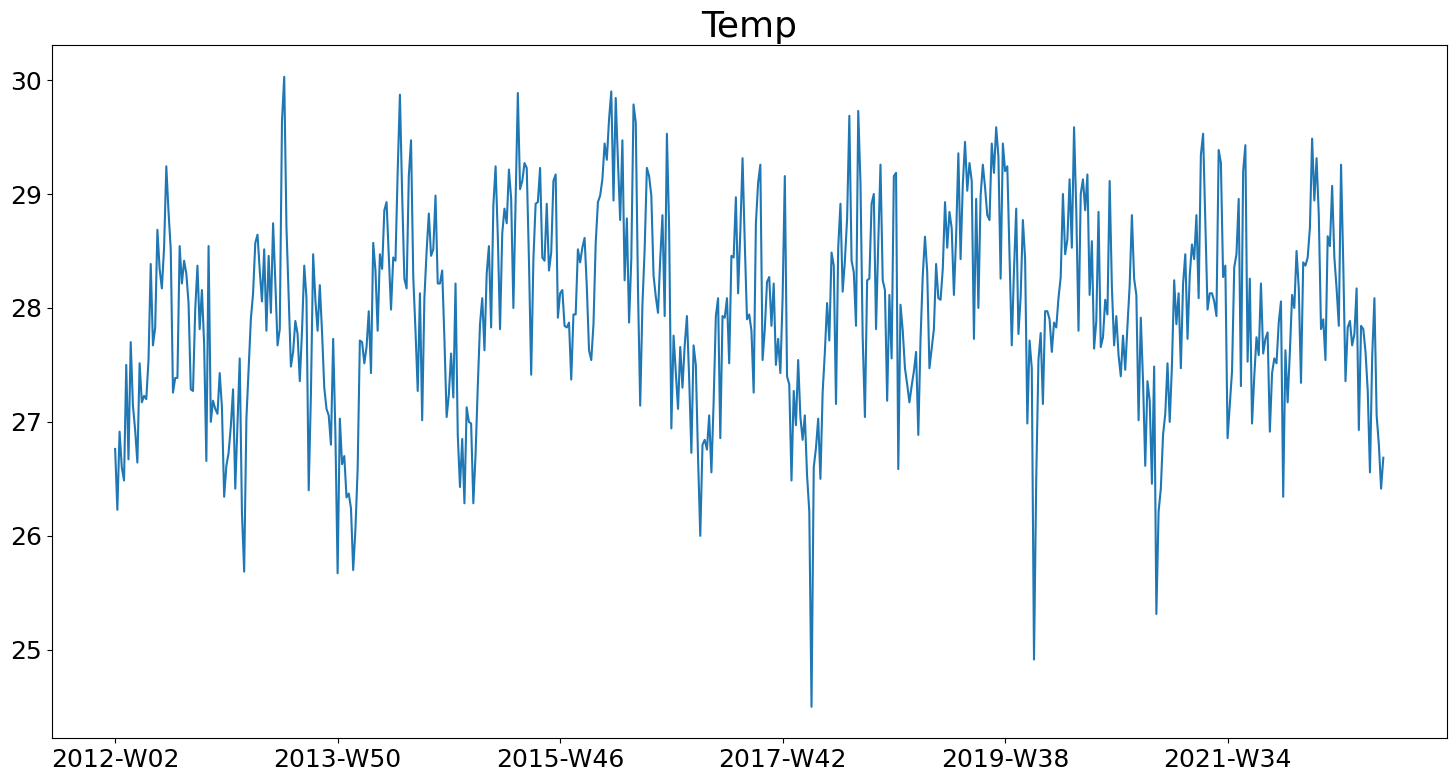

In [13]:
plot_series(df,['mean_temperature'], title='Temp', steps =100)

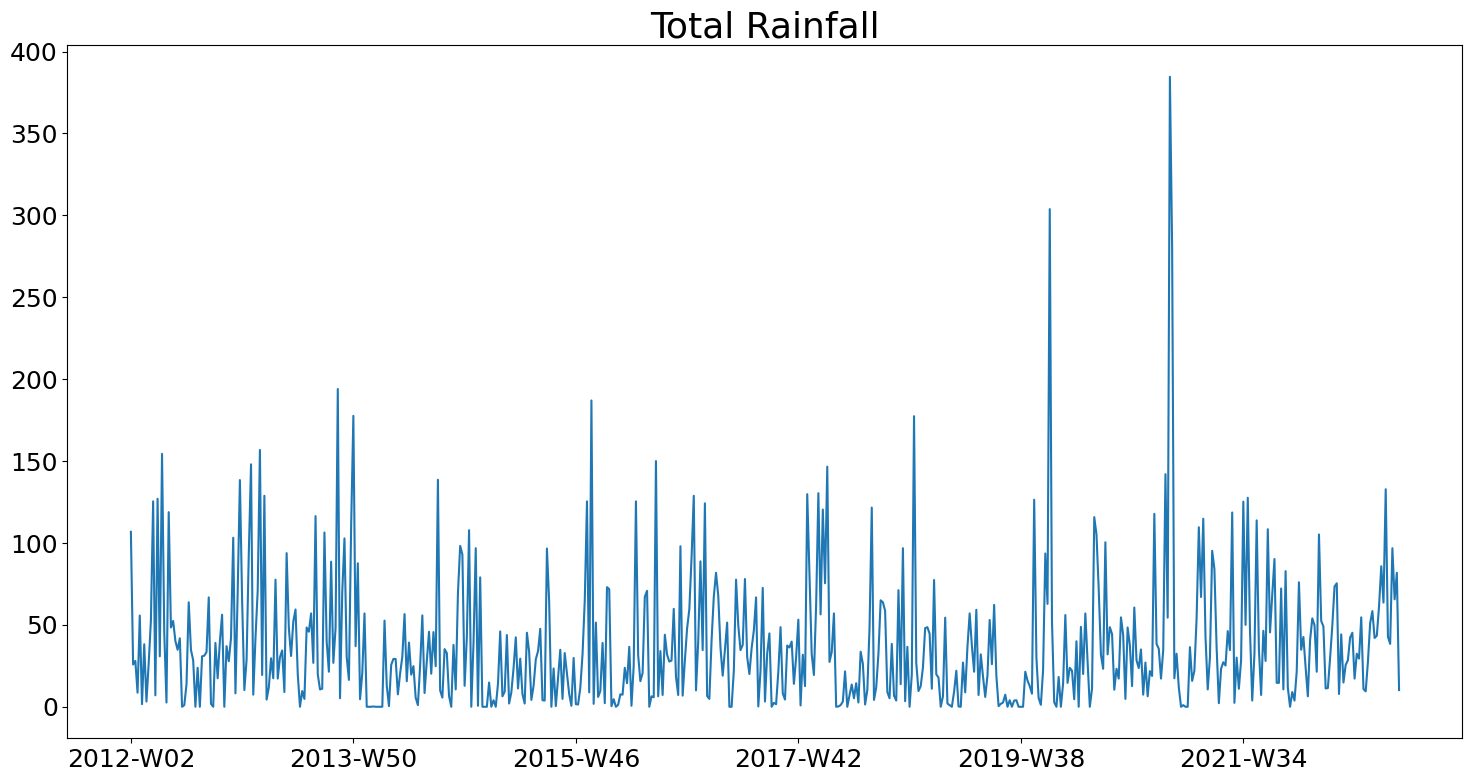

In [14]:
plot_series(df,['total_rainfall'], title='Total Rainfall', steps =100)

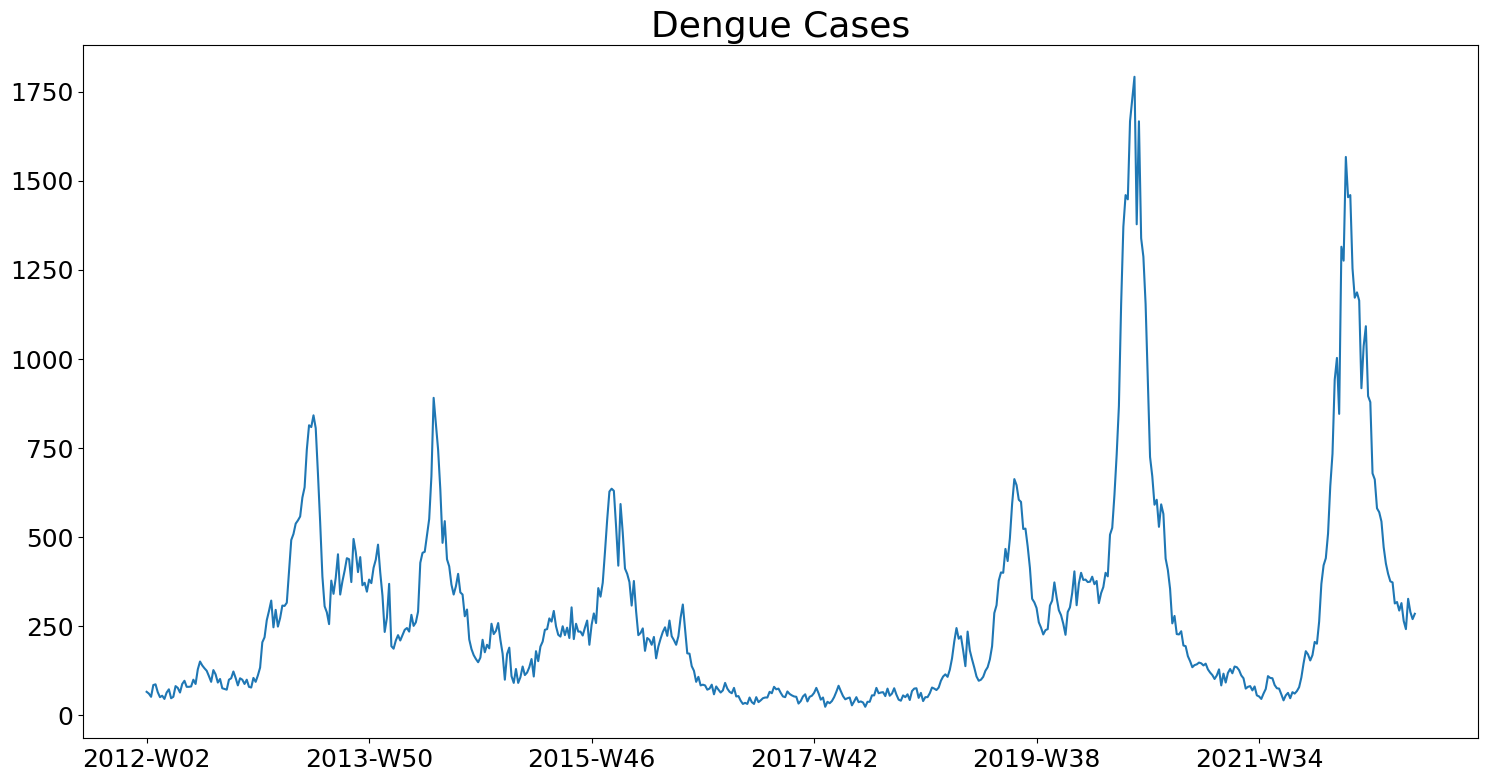

In [15]:
plot_series(df,['dengue_cases'], title='Dengue Cases', steps =100)

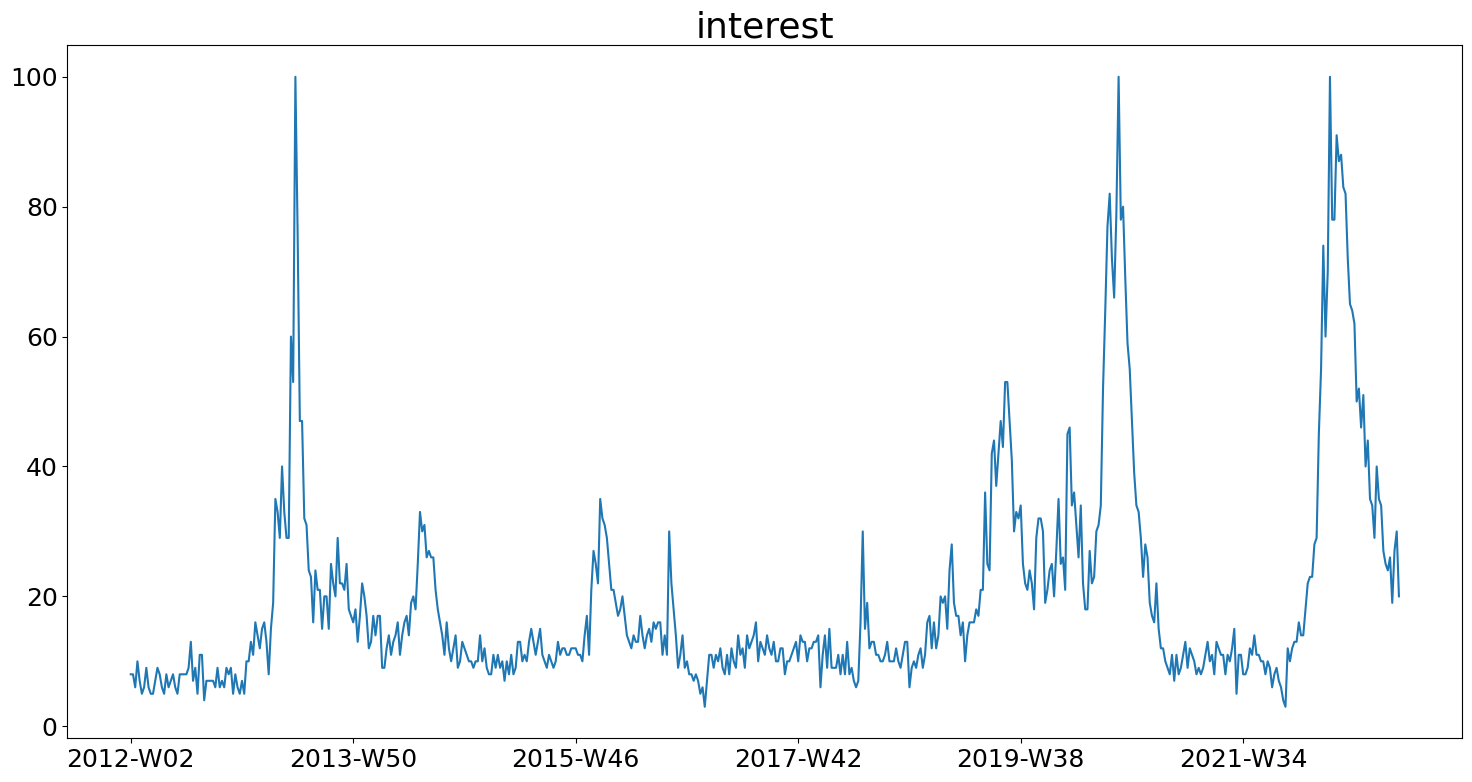

In [16]:
plot_series(df,['interest'], title='interest', steps =100)

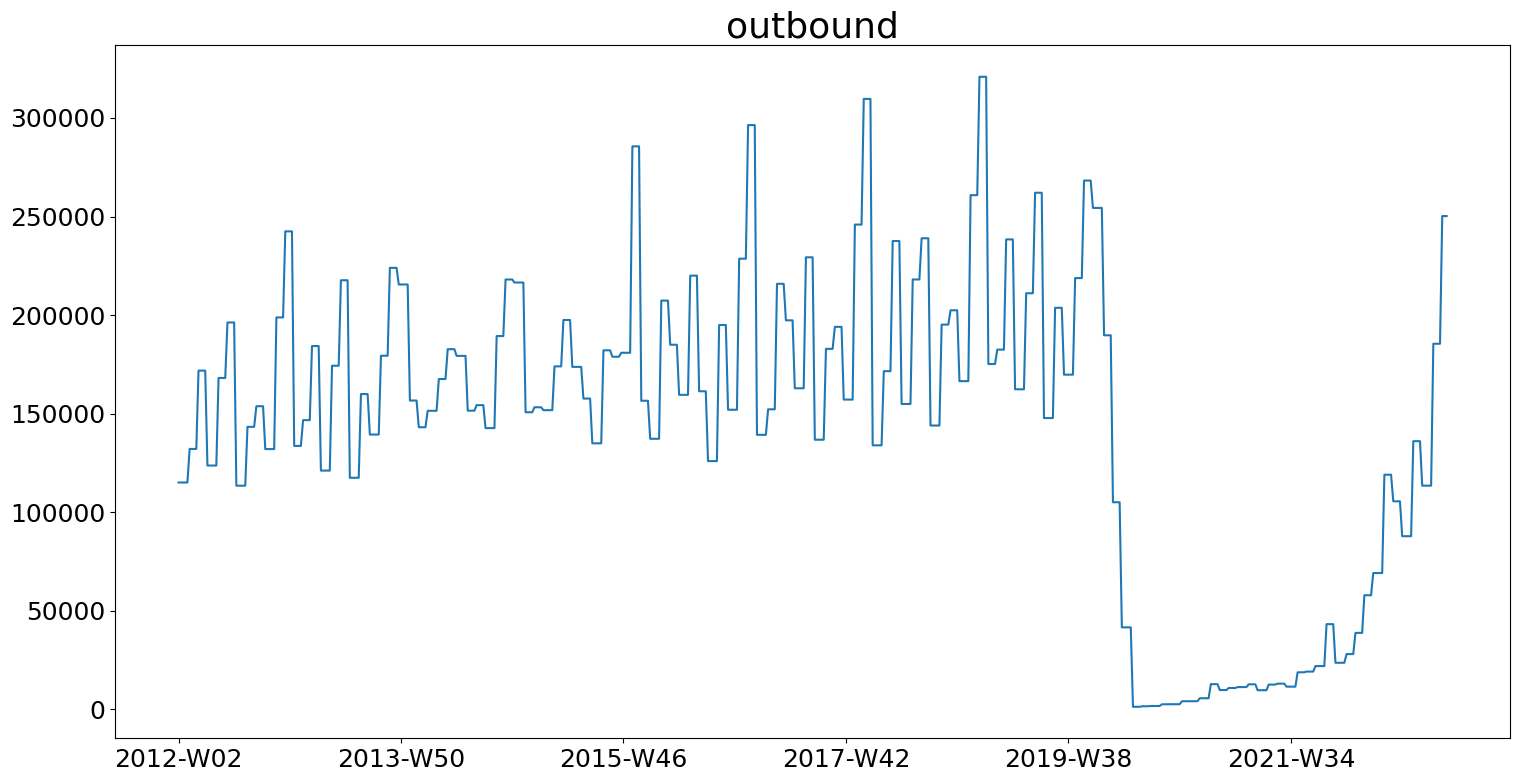

In [17]:
plot_series(df,['outbound'], title='outbound', steps =100)

create first and second different to check stationary

In [18]:
df['first_diff_dengue'] = df['dengue_cases'].diff()
df['second_diff_dengue'] = df['dengue_cases'].diff().diff()

In [19]:
adfuller(df['mean_temperature'])

(-5.173146951304727,
 9.972505912480068e-06,
 4,
 566,
 {'1%': -3.441956369604407,
  '5%': -2.8666599744723045,
  '10%': -2.5694967895716014},
 1056.392288299058)

In [20]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [21]:
interpret_dftest(adfuller(df['dengue_cases']))

Test Statistic   -3.728418
p-value           0.003731
dtype: float64

In [22]:
interpret_dftest(adfuller(df['first_diff_dengue'].dropna()))

Test Statistic   -7.740639e+00
p-value           1.064246e-11
dtype: float64

In [23]:
interpret_dftest(adfuller(df['second_diff_dengue'].dropna()))

Test Statistic   -9.096340e+00
p-value           3.706251e-15
dtype: float64

From this interpret, we can conduct one diffencing is enough

In [24]:
Weekly_dengue = pd.DataFrame(df['dengue_cases'])
Weekly_dengue

,dengue_cases
Unnamed: 0,
2012-W02,66
2012-W03,61
2012-W04,52
2012-W05,85
2012-W06,87
...,...
2022-W48,242
2022-W49,327
2022-W50,290


### Finding must way to split the data

In [25]:
print(f'Number of observations: {round(len(Weekly_dengue))} ')
print(f'Number of training observations: {round(len(Weekly_dengue) * 0.75)}')
print(f'Number of testing observations: {len(Weekly_dengue) - round(len(Weekly_dengue) * 0.75)}')

Number of observations: 571 
Number of training observations: 428
Number of testing observations: 143


In [26]:
print(f'Number of observations: {round(len(df))} ')
print(f'Number of training observations: {round(len(df) * 0.85)}')
print(f'Number of testing observations: {len(df) - round(len(df) * 0.85)}')

#train = Weekly_dengue.iloc[:430,]
#test = Weekly_dengue.iloc[430:,]

Number of observations: 571 
Number of training observations: 485
Number of testing observations: 86


In [27]:
print(f'Number of observations: {round(len(df))} ')
print(f'Number of training observations: {round(len(df) * 0.9)}')
print(f'Number of testing observations: {len(df) - round(len(df) * 0.9)}')

train = Weekly_dengue.iloc[:519,]
test = Weekly_dengue.iloc[519:,]

Number of observations: 571 
Number of training observations: 514
Number of testing observations: 57


we will use 10 year of data to predict 1 year data

### Create function for vision on train and pred vs actual data

In [28]:
def train_test_plot(train, actual, pred):
    """
    Function to return plot with 3 line of :train data set, actual data, predited data
    
    Parameters
    ----------
    
    train: pandas Dataframe
        training dataset
    
    actual: pandas Dataframe
        whole orignal dataset
        
    pred: pandas Dataframe
        pred dataset
        
    Returns
    -------
    plot
    
    """
    plt.figure(figsize=(16, 8))
    plt.plot(pred, c='orange',label='pred datset');
    plt.plot(actual, color = 'green',label='orginal data set')
    plt.plot(train, c='blue',label='train dataset')
    # Add legend
    plt.legend()

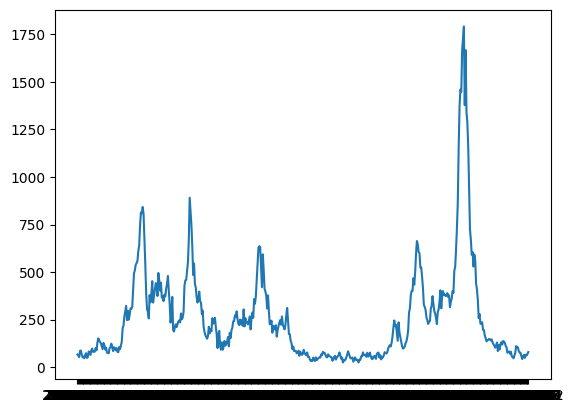

In [29]:
plt.plot(train['dengue_cases'])

Mean Squared Error: 16240.716583416264


Text(0.5, 0, 'year')

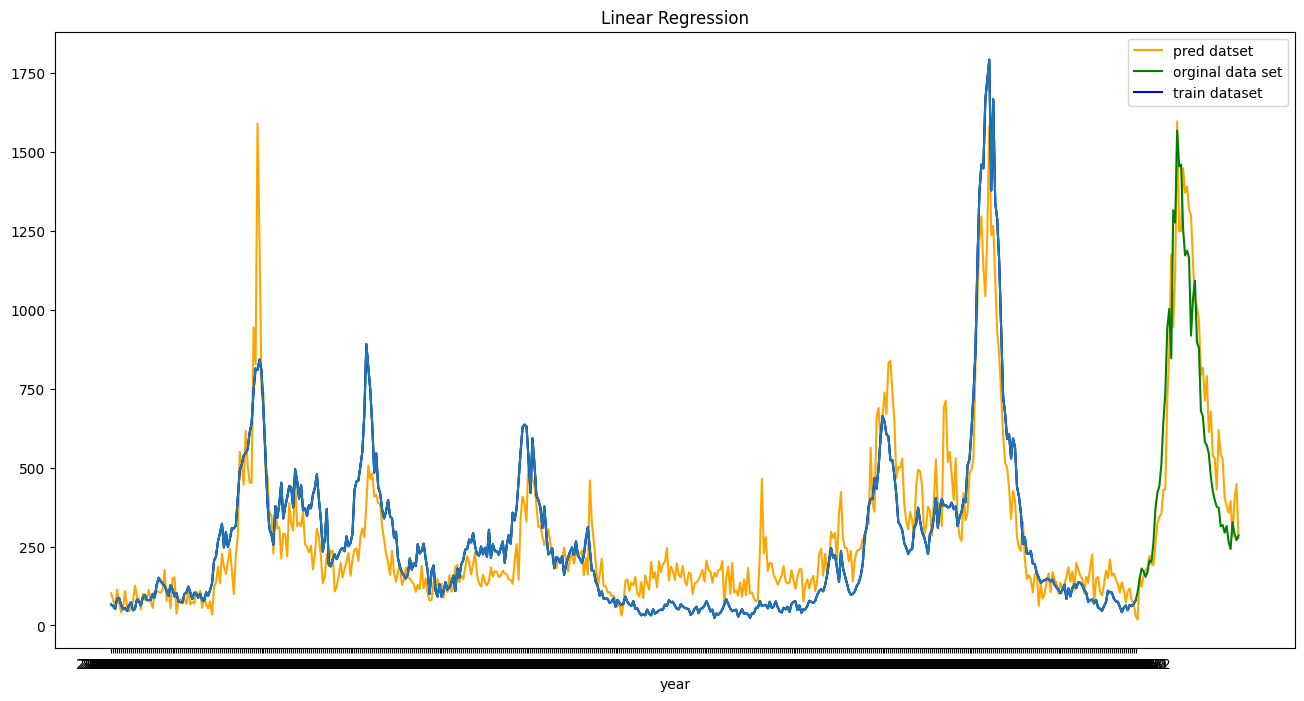

In [57]:
train = df.iloc[:519,]
test = df.iloc[519:,]

y = df['dengue_cases'].values.reshape(-1, 1)  # Input feature, reshaped to a 2D array
X = df[['mean_temperature','total_rainfall', 'interest']].values  # Target variable

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test= test[['mean_temperature','total_rainfall', 'interest']].values
y_test= test['dengue_cases'].values.reshape(-1, 1)

# Step 3: Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 4: Make predictions on the test set
y_pred_lr = model.predict(X)


# Step 5: Evaluate the model
mse = mean_squared_error(y, y_pred_lr)
print(f'Mean Squared Error: {mse}')

coef=list(model.coef_)
coef

actual_y_train= train['dengue_cases']
train_test_plot(actual_y_train, y ,y_pred_lr)
plt.plot(train['dengue_cases'])
plt.title('Linear Regression')
plt.xlabel('year')

Mean Squared Error: 16237.984185287498


[9.637371331456846, 0.17371628664285305, 16.155605111586237]

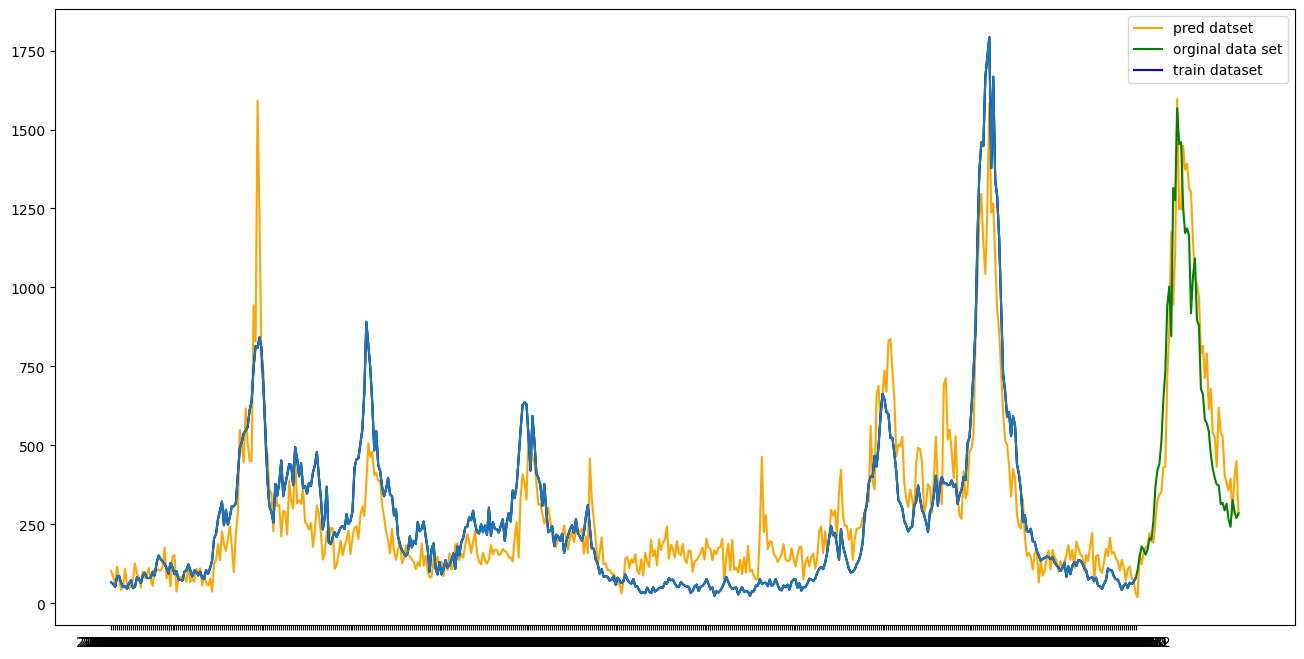

In [31]:
#train = df.iloc[:519,]
test = df.iloc[519:,]

y = df['dengue_cases'].values.reshape(-1, 1)  # Input feature, reshaped to a 2D array
X = df[['mean_temperature','total_rainfall', 'interest']].values  # Target variable

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test= test[['mean_temperature','total_rainfall', 'interest']].values
y_test= test['dengue_cases'].values.reshape(-1, 1)

# Step 3: Create and train the linear regression model
model = Lasso()
model.fit(X_train, y_train)

# Step 4: Make predictions on the test set
y_pred_lasso = model.predict(X)


# Step 5: Evaluate the model
mse = mean_squared_error(y, y_pred_lasso)
print(f'Mean Squared Error: {mse}')

actual_y_train= train['dengue_cases']
train_test_plot(actual_y_train, y ,y_pred_lasso)
plt.plot(train['dengue_cases'])

coef=list(model.coef_)
coef

Mean Squared Error: 16240.607228844441


[array([11.24111536,  0.18837997, 16.14706012])]

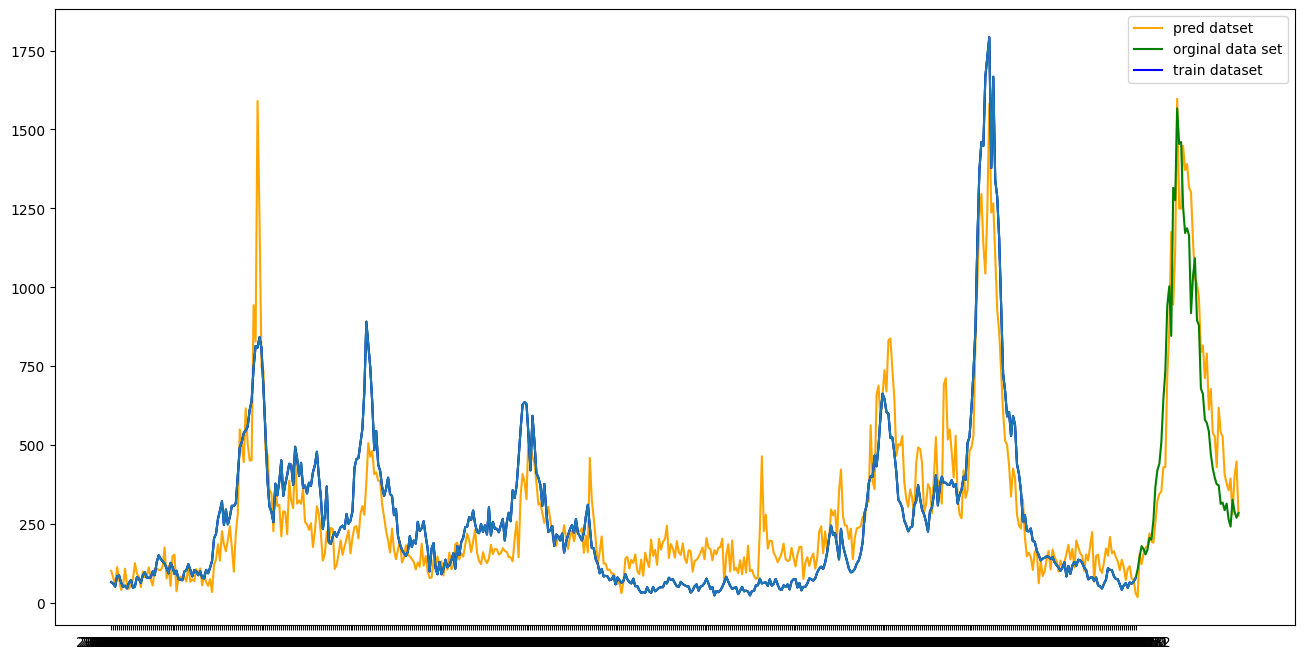

In [32]:
#train = df.iloc[:519,]
test = df.iloc[519:,]

y = df['dengue_cases'].values.reshape(-1, 1)  # Input feature, reshaped to a 2D array
X = df[['mean_temperature','total_rainfall', 'interest']].values  # Target variable

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test= test[['mean_temperature','total_rainfall', 'interest']].values
y_test= test['dengue_cases'].values.reshape(-1, 1)

# Step 3: Create and train the linear regression model
model = Ridge()
model.fit(X_train, y_train)

# Step 4: Make predictions on the test set
y_pred_ridge = model.predict(X)


# Step 5: Evaluate the model
mse = mean_squared_error(y, y_pred_ridge)
print(f'Mean Squared Error: {mse}')


actual_y_train= train['dengue_cases']
train_test_plot(actual_y_train, y ,y_pred_ridge)
plt.plot(train['dengue_cases'])

coef=list(model.coef_)
coef

In [54]:
df.shape

(571, 11)

### ARIMA MODEL

Testing ARIMA model with (1,0,0)

/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834

model aic: 5613.282976780472
model rmse 239982.25484497653


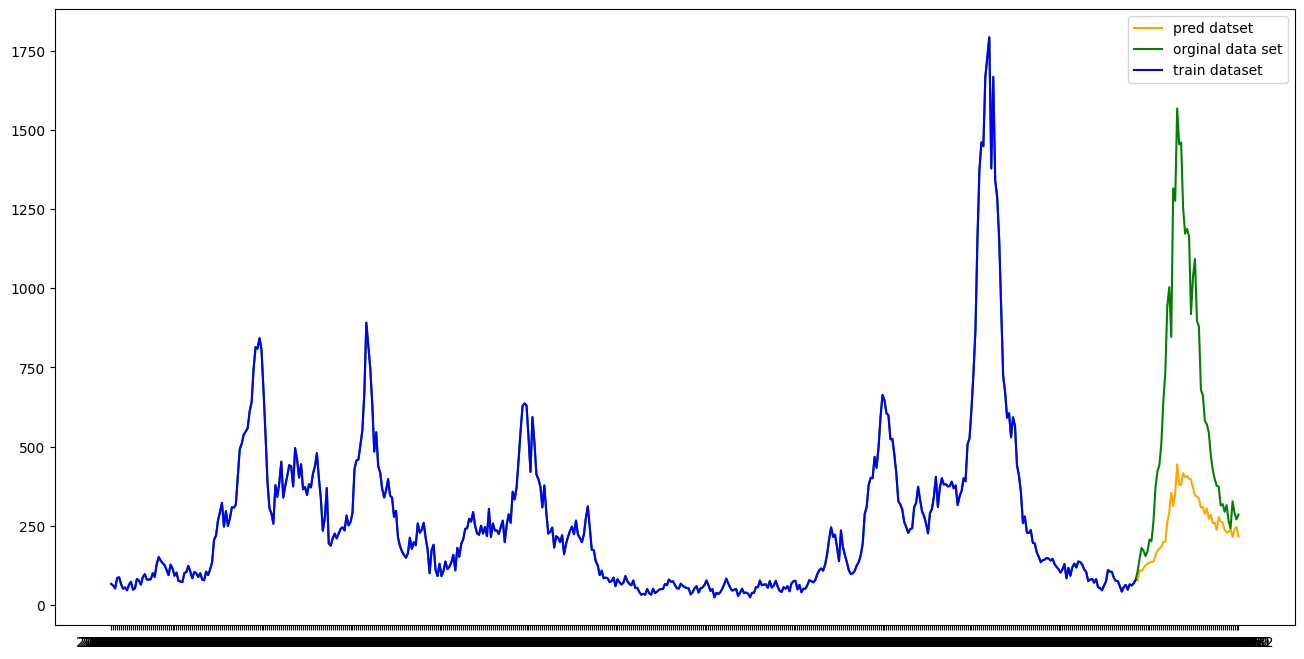

In [48]:
train = Weekly_dengue.iloc[:519,]
test = Weekly_dengue.iloc[519:,]

train_data = df.iloc[:519]
test_data = df.iloc[519:]

# Define ARIMA model
model = ARIMA(endog=train_data['dengue_cases'], 
              exog=train_data[['mean_temperature', 'total_rainfall', 'interest']], 
              order=(1, 0, 0))  # ARIMA order: (p, d, q)

# Fit ARIMA model
model_fit = model.fit()
predictions100 = model_fit.predict(start=519, 
                                 end=570, 
                                 exog=test_data[['mean_temperature', 'total_rainfall', 'interest']])

#Print predictions
#print(predictions200)

#print MSE
mse100 = mean_squared_error(test_data['dengue_cases'], predictions100)
model_aic= model_fit.aic
print(f'model aic: {model_aic}')
print(f'model rmse {mse100}')
train_test_plot(train,Weekly_dengue,predictions100)

Testing ARIMA model with (2,0,0)

/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


model aic: 5615.579225024596
model rmse 259315.18766526054


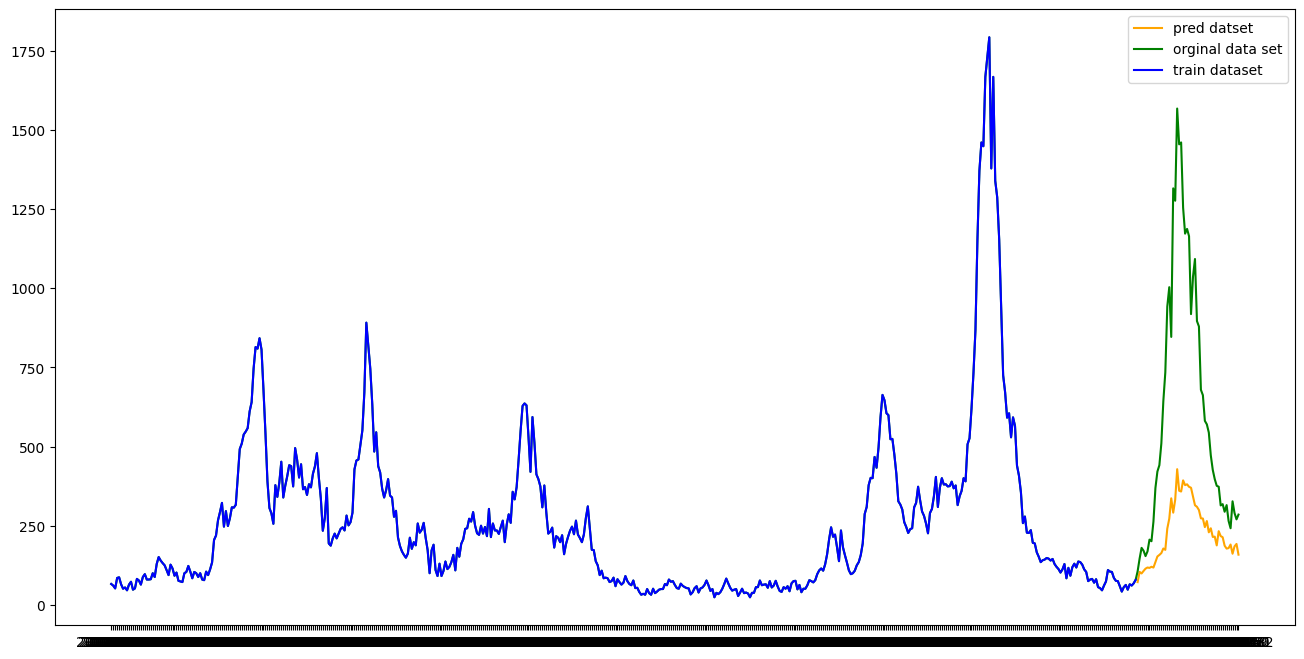

In [34]:
# Define ARIMA model
model = ARIMA(endog=train_data['dengue_cases'], 
              exog=train_data[['mean_temperature', 'total_rainfall', 'interest']], 
              order=(2, 0, 0))  # ARIMA order: (p, d, q)

# Fit ARIMA model
model_fit = model.fit()
predictions200 = model_fit.predict(start=519, 
                                 end=570, 
                                 exog=test_data[['mean_temperature', 'total_rainfall', 'interest']])

# Print predictions
#print(predictions202)

#print MSE
mse200 = mean_squared_error(test_data['dengue_cases'], predictions200)
model_aic= model_fit.aic
print(f'model aic: {model_aic}')
print(f'model rmse {mse200}')
train_test_plot(train,Weekly_dengue,predictions200)

Testing ARIMA model with (2,1,0)

/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


model aic: 5582.005470096941
model rmse 331843.5420666905


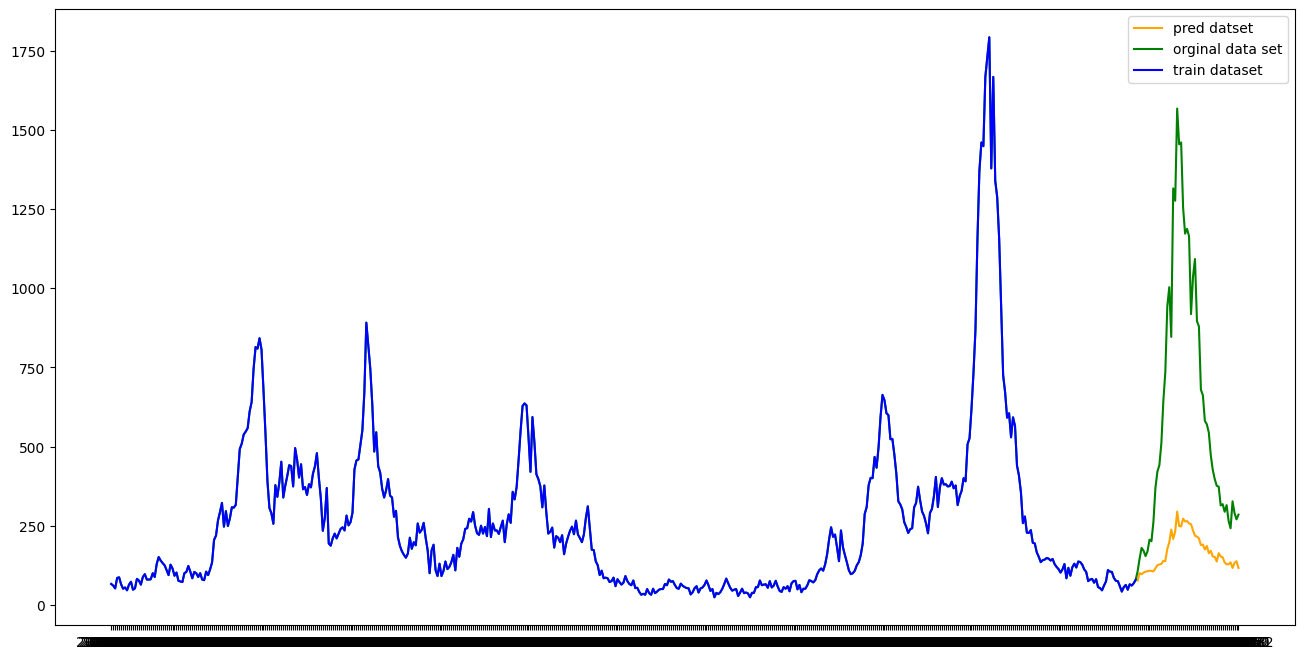

In [35]:
# Define ARIMA model
model = ARIMA(endog=train_data['dengue_cases'], 
              exog=train_data[['mean_temperature', 'total_rainfall', 'interest']], 
              order=(2, 1, 0))  # ARIMA order: (p, d, q)

# Fit ARIMA model
model_fit = model.fit()
predictions210 = model_fit.predict(start=519, 
                                 end=570, 
                                 exog=test_data[['mean_temperature', 'total_rainfall', 'interest']])

# Print predictions
#print(predictions210)

#print MSE
mse210 = mean_squared_error(test_data['dengue_cases'], predictions210)
model_aic= model_fit.aic
print(f'model aic: {model_aic}')
print(f'model rmse {mse210}')
train_test_plot(train,Weekly_dengue,predictions210)

### Gird search for ARIMA model Parameters. By best rmse

In [36]:
# Define ARIMA model parameters to search
p = [0,1, 2, 3]
d = [0, 1, 2]
q = [0, 1, 2]
params = list(product(p, d, q))

# Grid search to find optimal ARIMA model parameters
best_rmse = float('inf')
best_order = None
for param in params:
    try:
        model = ARIMA(endog=train_data['dengue_cases'], 
                      exog=train_data[['mean_temperature', 'total_rainfall', 'interest']], 
                      order=param)  # ARIMA order: (p, d, q)
        model_fit = model.fit()
        predictions = model_fit.predict(start=519, 
                                        end=570, 
                                        exog=test_data[['mean_temperature', 'total_rainfall', 'interest']])
        mse = mean_squared_error(test_data['dengue_cases'], predictions)
        rmse = np.sqrt(mse)
        if rmse < best_rmse:
            best_rmse = rmse
            best_order = param
        print(f' best rmse {rmse}')
    except:
        continue

# Fit ARIMA model with best parameters
best_model = ARIMA(endog=train_data['dengue_cases'], 
                   exog=train_data[['mean_temperature', 'total_rainfall', 'interest']], 
                   order=best_order)
best_model_fit = best_model.fit()

# Make predictions with best model
predictions = best_model_fit.predict(start=519, 
                                      end=570, 
                                      exog=test_data[['mean_temperature', 'total_rainfall', 'interest']])

# Print best model parameters and predictions
print("Best ARIMA Order: ", best_order)
print("Predictions: ", predictions)

mse = mean_squared_error(test_data['dengue_cases'], predictions)
print(f'model mse: {mse}')

/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_

 best rmse 174.526578450886
 best rmse 156.73575882247235


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_

 best rmse 199.51970411382922
 best rmse 542.2580448632622
 best rmse 536.6101335499598


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_

 best rmse 565.7245848374342
 best rmse 460.04015812383574


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_

 best rmse 541.4688164283358


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 best rmse 454.2465338284116


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/stats

 best rmse 489.87983714884257


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 best rmse 511.51160480341656


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/stats

 best rmse 551.698105270322
 best rmse 534.1469726300514


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 best rmse 558.4018881270007


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_

 best rmse 560.9022634416511
 best rmse 473.9624154817512


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_

 best rmse 464.7123175590617


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 best rmse 474.3215262503604


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/statespac

 best rmse 509.2299948601423


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/stats

 best rmse 554.6035896145162


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/stats

 best rmse 565.0795545287717


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 best rmse 576.0586272825801


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 best rmse 564.138057967389


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/stats

 best rmse 559.0085798116586


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 best rmse 459.7456545663828


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 best rmse 576.2406813157569


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/stats

 best rmse 470.3467165539839


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/stats

 best rmse 545.2656269758996


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/stats

 best rmse 579.3433730263024


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/stats

 best rmse 524.1683770308438
 best rmse 568.4707530561085


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_

 best rmse 561.7583881682457


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/stats

 best rmse 552.8339046170444


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 best rmse 445.505513269061


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 best rmse 568.0281733545648
 best rmse 575.889128301698
Best ARIMA Order:  (0, 0, 1)
Predictions:  519      58.204137
520     174.024346
521     145.036505
522     174.312700
523     190.324449
524     191.845015
525     229.720563
526     204.940778
527     203.135153
528     262.740077
529     322.644833
530     337.971441
531     340.769501
532     411.941438
533     421.639720
534     662.718487
535     806.281157
536    1083.265033
537     879.080786
538    1028.370483
539    1463.596029
540    1145.557838
541    1144.156025
542    1329.019135
543    1268.605083
544    1282.899496
545    1213.941886
546    1199.386242
547    1056.242007
548     951.901776
549     936.200901
550     904.506630
551     736.758318
552     761.780785
553     670.599906
554     743.957694
555     583.924299
556     641.886518
557     512.123302
558     499.669579
559     420.511247
560     585.003714
561     512.710374
562     498.140588
563     393.760643
564     363.944114
565     350.654336
566    

/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/stats

Fit best RMSE grid search ARIMA model

/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


model aic: 6237.672882475228
 best mse 24566.098093656223


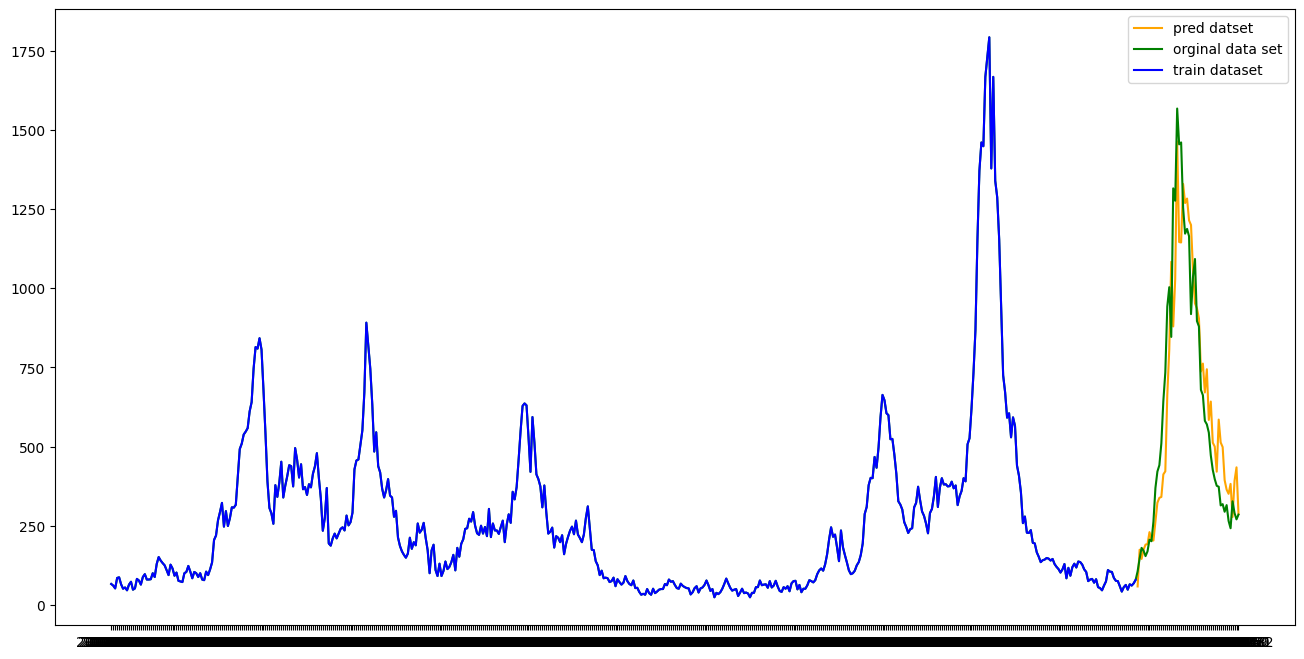

In [53]:
# Define ARIMA model best rmse parameter(3,2,0)
model = ARIMA(endog=train_data['dengue_cases'], 
              exog=train_data[['mean_temperature', 'total_rainfall', 'interest']], 
              order=(0, 0, 1))

# Fit ARIMA model
model_fit = model.fit()
predictions320 = model_fit.predict(start=519,
                                   end=570, 
                                   exog=test_data[['mean_temperature', 'total_rainfall', 'interest']])

# Print predictions
#print(predictions120)
model_aic= model_fit.aic
print(f'model aic: {model_aic}')
mse320 = mean_squared_error(test_data['dengue_cases'], predictions320)
print(f' best mse {mse320}')
train_test_plot(train,Weekly_dengue,predictions320)

### Gird search for ARIMA model Parameters. by best AIC

In [38]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16)
best_d = 0
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):
        for d in range(5):
                    try:
            
                        # Fitting an ARIMA(p, d, q) model.
                        print(f'Attempting ARIMA({p}, {d}, {q})')

                        # Instantiate ARIMA model.
                        arima = ARIMA(endog=train_data['dengue_cases'], 
                                      exog=train_data[['mean_temperature', 'total_rainfall', 'searches']], 
                                      order=(p, d, q))


                        # Fit ARIMA model.
                        model = arima.fit()#disp=False)

                        # Print out AIC for ARIMA(p, d, q) model.
                        print(f'The AIC for ARIMA({p},{d},{q}) is: {model.aic}')

                        # Is my current model's AIC better than our best_aic?
                        if model.aic < best_aic:

                            # If so, let's overwrite best_aic, best_p, and best_q.
                            best_aic = model.aic
                            best_p = p
                            best_q = q
                            best_d = d


                    except:
                        pass
            

#print()
#print()
print('MODEL FINISHED!')

print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting ARIMA(0, 0, 0)
Attempting ARIMA(0, 1, 0)
Attempting ARIMA(0, 2, 0)
Attempting ARIMA(0, 3, 0)
Attempting ARIMA(0, 4, 0)
Attempting ARIMA(0, 0, 1)
Attempting ARIMA(0, 1, 1)
Attempting ARIMA(0, 2, 1)
Attempting ARIMA(0, 3, 1)
Attempting ARIMA(0, 4, 1)
Attempting ARIMA(0, 0, 2)
Attempting ARIMA(0, 1, 2)
Attempting ARIMA(0, 2, 2)
Attempting ARIMA(0, 3, 2)
Attempting ARIMA(0, 4, 2)
Attempting ARIMA(0, 0, 3)
Attempting ARIMA(0, 1, 3)
Attempting ARIMA(0, 2, 3)
Attempting ARIMA(0, 3, 3)
Attempting ARIMA(0, 4, 3)
Attempting ARIMA(0, 0, 4)
Attempting ARIMA(0, 1, 4)
Attempting ARIMA(0, 2, 4)
Attempting ARIMA(0, 3, 4)
Attempting ARIMA(0, 4, 4)
Attempting ARIMA(1, 0, 0)
Attempting ARIMA(1, 1, 0)
Attempting ARIMA(1, 2, 0)
Attempting ARIMA(1, 3, 0)
Attempting ARIMA(1, 4, 0)
Attempting ARIMA(1, 0, 1)
Attempting ARIMA(1, 1, 1)
Attempting ARIMA(1, 2, 1)
Attempting ARIMA(1, 3, 1)
Attempting ARIMA(1, 4, 1)
Attempting ARIMA(1, 0, 2)
Attempting ARIMA(1, 1, 2)
Attempting ARIMA(1, 2, 2)
Attempting A

Fit best AIC grid search ARIMA model

 best mse 294043.78721892764
model aic: 5603.1536976902225


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


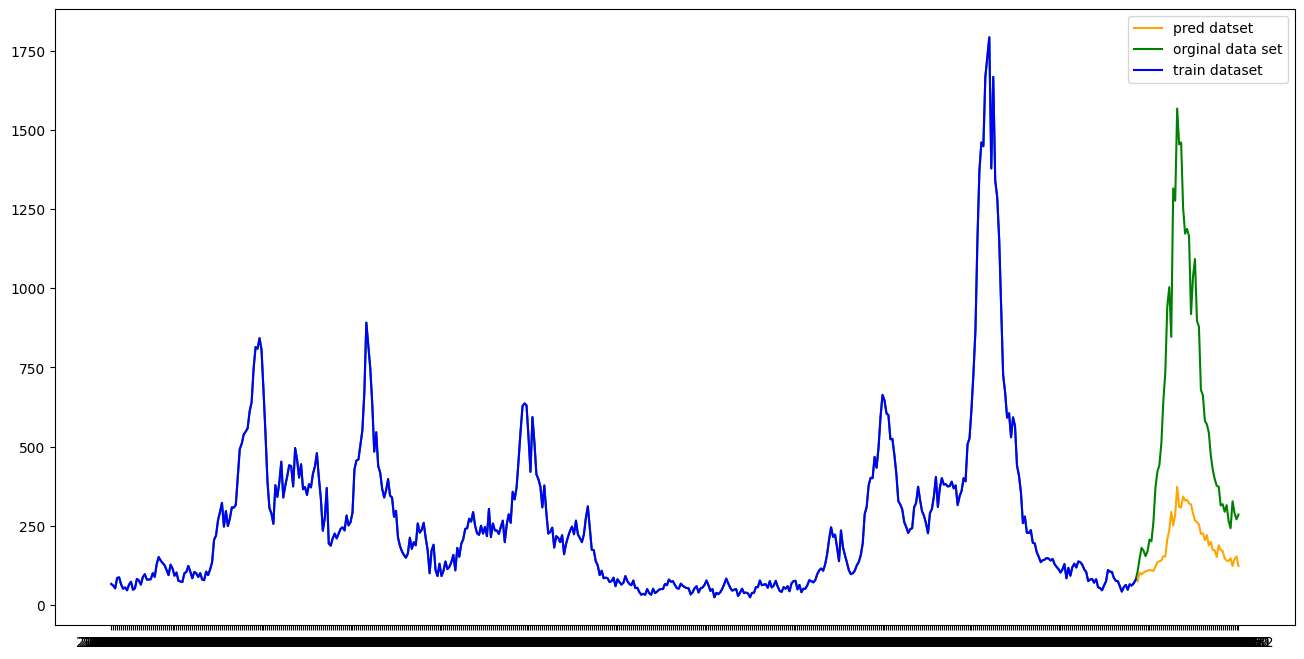

In [39]:
# Define ARIMA model
model = ARIMA(endog=train_data['dengue_cases'], 
              exog=train_data[['mean_temperature', 'total_rainfall', 'interest']], 
              order=(0, 1, 0))  # ARIMA order: (p, d, q)

# Fit ARIMA model
model_fit = model.fit()
predictions010 = model_fit.predict(start=519,
                                   end=570, 
                                   exog=test_data[['mean_temperature', 'total_rainfall', 'interest']])

# Print predictions
#print(predictions010)
mse = mean_squared_error(test_data['dengue_cases'], predictions010)
print(f' best mse {mse}')
model_aic= model_fit.aic
print(f'model aic: {model_aic}')
train_test_plot(train,Weekly_dengue,predictions010)

### Check for seasonal 

/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


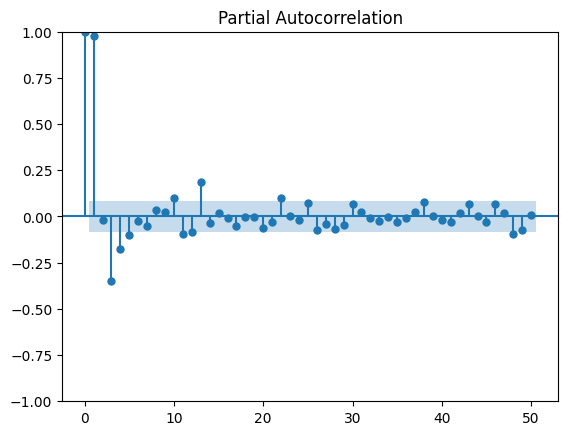

In [40]:
plot_pacf(df['dengue_cases'],lags=50);

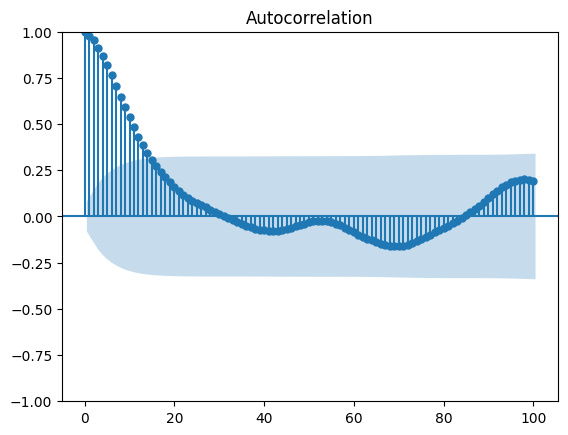

In [41]:
plot_acf(df['dengue_cases'],lags=100);

no seasonality is found

### Fit SARIMA Model

/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


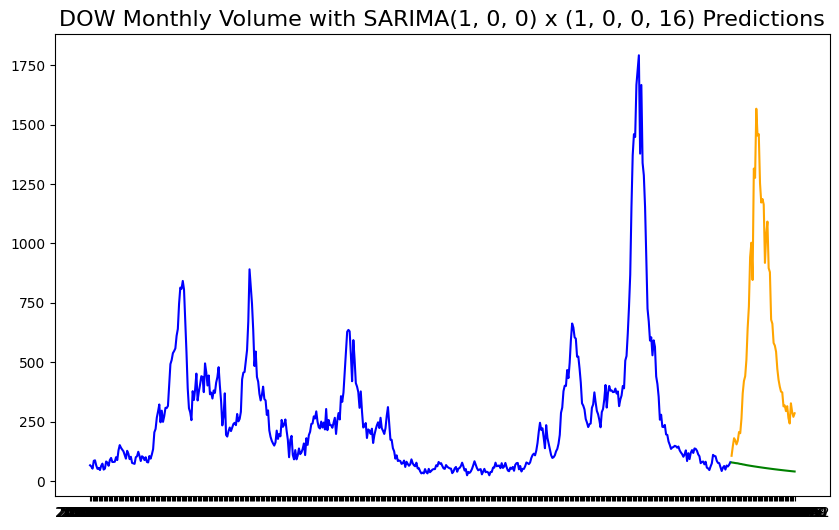

In [42]:
# Fit a SARIMA(1, 0, 0) x (1, 0, 0, 13) model.

sarima = SARIMAX(endog = train['dengue_cases'],
                 order = (1, 0, 0),              # (p, d, q)
                 seasonal_order = (1, 0, 0, 13)) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit(disp=False)

# Generate predictions based on test set.
preds = model.predict(start=len(train_data), 
                              end=len(train_data) + len(test_data) - 1,)

# Evaluate predictions.
#print(mean_squared_error(test['dengue_cases'], preds))

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train['dengue_cases'], color = 'blue')
plt.plot(test['dengue_cases'], color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'DOW Monthly Volume with SARIMA(1, 0, 0) x (1, 0, 0, 16) Predictions', fontsize=16)
plt.show();

Try search for best parameter for SARIMAX

In [43]:
def sarimax(ts,exo,all_param):
    results = []
    for param in all_param:
        try:
            mod = SARIMAX(ts,
                          exog = exo,
                          order=param[0],
                          seasonal_order=param[1])
            res = mod.fit()
            results.append((res,res.aic,param))
            print('Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], round(res.aic,2)))
        except Exception as e:
            print(e)
            continue
            
    return results

# set parameter range
p,d,q = range(1,3),[1],range(1,3)
P,D,Q,s = range(0,3),[1],range(0,3),[30]
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq,seasonal_pdq))

all_res = sarimax(train,train_data[['mean_temperature', 'total_rainfall', 'interest']],all_param)

/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.44245D+00    |proj g|=  1.01291D-01

At iterate    5    f=  5.43747D+00    |proj g|=  1.56598D-02

At iterate   10    f=  5.42990D+00    |proj g|=  1.40282D-02

At iterate   15    f=  5.42924D+00    |proj g|=  1.57742D-03

At iterate   20    f=  5.42916D+00    |proj g|=  1.35876D-03

At iterate   25    f=  5.42902D+00    |proj g|=  1.74432D-03

At iterate   30    f=  5.42901D+00    |proj g|=  4.36424D-04

At iterate   35    f=  5.42898D+00    |proj g|=  4.05527D-04

At iterate   40    f=  5.42896D+00    |proj g|=  2.46849D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.24860D+00    |proj g|=  6.45732D-02

At iterate    5    f=  5.24312D+00    |proj g|=  2.30987D-02

At iterate   10    f=  5.21777D+00    |proj g|=  5.33890D-03

At iterate   15    f=  5.17089D+00    |proj g|=  1.55321D-02

At iterate   20    f=  5.15573D+00    |proj g|=  2.57094D-04

At iterate   25    f=  5.15533D+00    |proj g|=  5.18613D-03

At iterate   30    f=  5.15527D+00    |proj g|=  1.07143D-04

At iterate   35    f=  5.15515D+00    |proj g|=  8.01655D-04

At iterate   40    f=  5.15422D+00    |proj g|=  5.91257D-03

At iterate   45    f=  5.15339D+00    |proj g|=  2.08201D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.25605D+00    |proj g|=  6.59152D-02

At iterate    5    f=  5.24848D+00    |proj g|=  3.51793D-02

At iterate   10    f=  5.23247D+00    |proj g|=  5.82132D-03

At iterate   15    f=  5.20056D+00    |proj g|=  1.55127D-02

At iterate   20    f=  5.15584D+00    |proj g|=  2.00550D-03

At iterate   25    f=  5.15562D+00    |proj g|=  2.28848D-03

At iterate   30    f=  5.15501D+00    |proj g|=  2.91035D-03

At iterate   35    f=  5.15452D+00    |proj g|=  4.55569D-03

At iterate   40    f=  5.15445D+00    |proj g|=  8.81603D-04

At iterate   45    f=  5.15443D+00    |proj g|=  1.89115D-04


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.15441D+00    |proj g|=  2.20682D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   2.207D-03   5.154D+00
  F =   5.1544103754197002     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 1)x(0, 1, 2, 30) - AIC:5366.28


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.32419D+00    |proj g|=  8.05984D-02

At iterate    5    f=  5.31915D+00    |proj g|=  5.62792D-03

At iterate   10    f=  5.31031D+00    |proj g|=  1.06220D-02

At iterate   15    f=  5.30594D+00    |proj g|=  4.23935D-02

At iterate   20    f=  5.29784D+00    |proj g|=  2.98185D-02

At iterate   25    f=  5.29078D+00    |proj g|=  6.98218D-04

At iterate   30    f=  5.29078D+00    |proj g|=  2.17918D-04

At iterate   35    f=  5.29076D+00    |proj g|=  2.06678D-03

At iterate   40    f=  5.29075D+00    |proj g|=  2.02051D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.25106D+00    |proj g|=  6.84993D-02

At iterate    5    f=  5.24156D+00    |proj g|=  1.20102D-02

At iterate   10    f=  5.23531D+00    |proj g|=  2.16313D-02

At iterate   15    f=  5.19675D+00    |proj g|=  7.94764D-02

At iterate   20    f=  5.16523D+00    |proj g|=  1.08538D-01

At iterate   25    f=  5.15448D+00    |proj g|=  1.11729D-03

At iterate   30    f=  5.15437D+00    |proj g|=  4.08640D-04

At iterate   35    f=  5.15396D+00    |proj g|=  3.10150D-03

At iterate   40    f=  5.15313D+00    |proj g|=  1.20785D-03

At iterate   45    f=  5.15309D+00    |proj g|=  2.43033D-03


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.15248D+00    |proj g|=  1.57761D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     65      1     0     0   1.578D-02   5.152D+00
  F =   5.1524828689344915     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 1)x(1, 1, 1, 30) - AIC:5364.28


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.25753D+00    |proj g|=  6.54424D-02


 This problem is unconstrained.



At iterate    5    f=  5.24578D+00    |proj g|=  5.67088D-02

At iterate   10    f=  5.23905D+00    |proj g|=  2.01485D-02

At iterate   15    f=  5.19900D+00    |proj g|=  8.74815D-02

At iterate   20    f=  5.15986D+00    |proj g|=  1.68094D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     24     41      1     0     0   4.319D-03   5.155D+00
  F =   5.1547630227339392     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Tried out SARIMAX(1, 1, 1)x(1, 1, 2, 30) - AIC:5368.64


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.27889D+00    |proj g|=  7.61266D-02


 This problem is unconstrained.



At iterate    5    f=  5.27217D+00    |proj g|=  9.01195D-03

At iterate   10    f=  5.25962D+00    |proj g|=  2.18076D-02

At iterate   15    f=  5.25537D+00    |proj g|=  3.84134D-02

At iterate   20    f=  5.23195D+00    |proj g|=  8.42672D-02

At iterate   25    f=  5.22373D+00    |proj g|=  4.04814D-03

At iterate   30    f=  5.22349D+00    |proj g|=  4.63939D-03

At iterate   35    f=  5.22071D+00    |proj g|=  3.94314D-02

At iterate   40    f=  5.21585D+00    |proj g|=  4.38267D-02

At iterate   45    f=  5.21305D+00    |proj g|=  4.03447D-03


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.21225D+00    |proj g|=  1.66064D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     59      1     0     0   1.661D-03   5.212D+00
  F =   5.2122539945407311     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 1)x(2, 1, 0, 30) - AIC:5426.32


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.25854D+00    |proj g|=  7.36665D-02


 This problem is unconstrained.



At iterate    5    f=  5.24064D+00    |proj g|=  2.57721D-02

At iterate   10    f=  5.23014D+00    |proj g|=  1.28837D-02

At iterate   15    f=  5.18327D+00    |proj g|=  1.95593D-02

At iterate   20    f=  5.15256D+00    |proj g|=  2.25234D-03

At iterate   25    f=  5.15255D+00    |proj g|=  3.14862D-04

At iterate   30    f=  5.15252D+00    |proj g|=  6.21352D-03

At iterate   35    f=  5.15200D+00    |proj g|=  1.05313D-02

At iterate   40    f=  5.15186D+00    |proj g|=  2.14192D-04

At iterate   45    f=  5.15185D+00    |proj g|=  1.26275D-03


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.15174D+00    |proj g|=  3.99235D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58      1     0     0   3.992D-03   5.152D+00
  F =   5.1517441898207865     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 1)x(2, 1, 1, 30) - AIC:5365.51


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.25108D+00    |proj g|=  6.92742D-02


 This problem is unconstrained.



At iterate    5    f=  5.24074D+00    |proj g|=  1.02879D-02

At iterate   10    f=  5.23168D+00    |proj g|=  2.56998D-02

At iterate   15    f=  5.17038D+00    |proj g|=  4.03453D-02

At iterate   20    f=  5.15559D+00    |proj g|=  4.26299D-02

At iterate   25    f=  5.15279D+00    |proj g|=  4.30857D-03

At iterate   30    f=  5.15270D+00    |proj g|=  1.98941D-03

At iterate   35    f=  5.15107D+00    |proj g|=  2.59883D-02

At iterate   40    f=  5.15007D+00    |proj g|=  3.16396D-03

At iterate   45    f=  5.15005D+00    |proj g|=  1.16445D-03


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.14902D+00    |proj g|=  1.04333D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     59      1     0     0   1.043D-02   5.149D+00
  F =   5.1490151042208900     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 1)x(2, 1, 2, 30) - AIC:5364.68
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.41195D+00    |proj g|=  1.16305D-02


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  5.40892D+00    |proj g|=  3.13015D-03

At iterate   10    f=  5.40832D+00    |proj g|=  2.62423D-03

At iterate   15    f=  5.40828D+00    |proj g|=  2.50273D-03

At iterate   20    f=  5.40814D+00    |proj g|=  9.87374D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     26      1     0     0   3.105D-05   5.408D+00
  F =   5.4081433620144876     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(1, 1, 2)x(0, 1, 0, 30) - AIC:5627.65


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.22072D+00    |proj g|=  1.24515D-02


 This problem is unconstrained.



At iterate    5    f=  5.21581D+00    |proj g|=  3.09716D-02

At iterate   10    f=  5.20111D+00    |proj g|=  3.00200D-02

At iterate   15    f=  5.16031D+00    |proj g|=  6.65431D-02

At iterate   20    f=  5.12635D+00    |proj g|=  3.55875D-02

At iterate   25    f=  5.11970D+00    |proj g|=  1.50083D-02

At iterate   30    f=  5.11805D+00    |proj g|=  3.73297D-03

At iterate   35    f=  5.11784D+00    |proj g|=  8.09536D-04

At iterate   40    f=  5.11781D+00    |proj g|=  3.69202D-04

At iterate   45    f=  5.11780D+00    |proj g|=  1.18590D-03


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.11780D+00    |proj g|=  7.93780D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57      1     0     0   7.938D-04   5.118D+00
  F =   5.1177951914517807     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 2)x(0, 1, 1, 30) - AIC:5328.27


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.22724D+00    |proj g|=  1.61969D-02

At iterate    5    f=  5.21483D+00    |proj g|=  4.28541D-02

At iterate   10    f=  5.20933D+00    |proj g|=  5.97598D-03

At iterate   15    f=  5.18125D+00    |proj g|=  4.19946D-02

At iterate   20    f=  5.15963D+00    |proj g|=  8.04931D-02

At iterate   25    f=  5.12429D+00    |proj g|=  1.60284D-02

At iterate   30    f=  5.11599D+00    |proj g|=  1.00279D-02

At iterate   35    f=  5.11586D+00    |proj g|=  2.14382D-04

At iterate   40    f=  5.11558D+00    |proj g|=  1.37736D-02

At iterate   45    f=  5.11528D+00    |proj g|=  1.73235D-03

At iterate   50    f=  5.11527D+00    |proj g|=  6.29171D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 1, 2)x(0, 1, 2, 30) - AIC:5327.65


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.29801D+00    |proj g|=  2.43885D-02


 This problem is unconstrained.



At iterate    5    f=  5.29501D+00    |proj g|=  1.42849D-02

At iterate   10    f=  5.29297D+00    |proj g|=  1.35161D-02

At iterate   15    f=  5.28999D+00    |proj g|=  5.39377D-03

At iterate   20    f=  5.27271D+00    |proj g|=  3.24933D-02

At iterate   25    f=  5.27091D+00    |proj g|=  7.51027D-05

At iterate   30    f=  5.27091D+00    |proj g|=  4.08264D-04

At iterate   35    f=  5.27091D+00    |proj g|=  4.66101D-04

At iterate   40    f=  5.27089D+00    |proj g|=  4.96972D-04

At iterate   45    f=  5.27089D+00    |proj g|=  5.33829D-04


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.27089D+00    |proj g|=  1.21015D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     56      1     0     0   1.210D-04   5.271D+00
  F =   5.2708911241065852     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 2)x(1, 1, 0, 30) - AIC:5487.18


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.22321D+00    |proj g|=  2.42465D-02

At iterate    5    f=  5.21594D+00    |proj g|=  6.20729D-03

At iterate   10    f=  5.20168D+00    |proj g|=  1.45859D-02

At iterate   15    f=  5.15360D+00    |proj g|=  3.67518D-02

At iterate   20    f=  5.13800D+00    |proj g|=  1.22784D-02

At iterate   25    f=  5.11580D+00    |proj g|=  5.03177D-03

At iterate   30    f=  5.11576D+00    |proj g|=  1.20184D-04

At iterate   35    f=  5.11574D+00    |proj g|=  1.49183D-03

At iterate   40    f=  5.11574D+00    |proj g|=  9.69754D-05

At iterate   45    f=  5.11574D+00    |proj g|=  4.45303D-04


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.11572D+00    |proj g|=  6.77157D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     62      1     0     0   6.772D-04   5.116D+00
  F =   5.1157168952882150     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 2)x(1, 1, 1, 30) - AIC:5328.11


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.22905D+00    |proj g|=  2.35067D-02

At iterate    5    f=  5.21553D+00    |proj g|=  7.87561D-03

At iterate   10    f=  5.20428D+00    |proj g|=  3.05056D-02

At iterate   15    f=  5.17337D+00    |proj g|=  3.86790D-02

At iterate   20    f=  5.14208D+00    |proj g|=  1.44313D-02

At iterate   25    f=  5.11996D+00    |proj g|=  3.62240D-02

At iterate   30    f=  5.11596D+00    |proj g|=  2.47337D-03

At iterate   35    f=  5.11588D+00    |proj g|=  2.07991D-03

At iterate   40    f=  5.11576D+00    |proj g|=  1.70211D-03

At iterate   45    f=  5.11495D+00    |proj g|=  5.94220D-03


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.11469D+00    |proj g|=  3.75333D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     58      1     0     0   3.753D-04   5.115D+00
  F =   5.1146943887460230     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 2)x(1, 1, 2, 30) - AIC:5329.05


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.24825D+00    |proj g|=  2.75551D-02

At iterate    5    f=  5.24416D+00    |proj g|=  2.13556D-02

At iterate   10    f=  5.23966D+00    |proj g|=  9.49833D-03

At iterate   15    f=  5.22865D+00    |proj g|=  1.09936D-02

At iterate   20    f=  5.19140D+00    |proj g|=  9.00624D-02

At iterate   25    f=  5.18470D+00    |proj g|=  3.01183D-04

At iterate   30    f=  5.18469D+00    |proj g|=  1.74574D-03

At iterate   35    f=  5.18446D+00    |proj g|=  1.26275D-03

At iterate   40    f=  5.18445D+00    |proj g|=  1.58357D-04

At iterate   45    f=  5.18445D+00    |proj g|=  2.32256D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.22858D+00    |proj g|=  3.50457D-02


 This problem is unconstrained.



At iterate    5    f=  5.21389D+00    |proj g|=  9.32800D-03

At iterate   10    f=  5.20950D+00    |proj g|=  2.49766D-02

At iterate   15    f=  5.18717D+00    |proj g|=  2.33110D-02

At iterate   20    f=  5.15866D+00    |proj g|=  5.66364D-02

At iterate   25    f=  5.13181D+00    |proj g|=  5.06821D-02

At iterate   30    f=  5.11316D+00    |proj g|=  7.80895D-03

At iterate   35    f=  5.11246D+00    |proj g|=  4.26099D-04

At iterate   40    f=  5.11246D+00    |proj g|=  3.99779D-04

At iterate   45    f=  5.11240D+00    |proj g|=  4.27832D-03


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.11236D+00    |proj g|=  3.69171D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     54      1     0     0   3.692D-05   5.112D+00
  F =   5.1123584061043612     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 2)x(2, 1, 1, 30) - AIC:5326.63


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.22098D+00    |proj g|=  4.87092D-02

At iterate    5    f=  5.21471D+00    |proj g|=  7.15135D-03

At iterate   10    f=  5.20394D+00    |proj g|=  1.15807D-02

At iterate   15    f=  5.18715D+00    |proj g|=  2.65069D-02

At iterate   20    f=  5.15083D+00    |proj g|=  3.73141D-02

At iterate   25    f=  5.12895D+00    |proj g|=  5.09244D-02

At iterate   30    f=  5.11419D+00    |proj g|=  1.77326D-03

At iterate   35    f=  5.11414D+00    |proj g|=  4.47143D-04

At iterate   40    f=  5.11408D+00    |proj g|=  4.01023D-03

At iterate   45    f=  5.11400D+00    |proj g|=  2.12467D-03


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.11392D+00    |proj g|=  6.66316D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     60      1     0     0   6.663D-03   5.114D+00
  F =   5.1139249735792109     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 2)x(2, 1, 2, 30) - AIC:5330.25
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.41154D+00    |proj g|=  1.27507D-02


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  5.40921D+00    |proj g|=  1.79043D-02

At iterate   10    f=  5.40852D+00    |proj g|=  4.82358D-03

At iterate   15    f=  5.40846D+00    |proj g|=  3.39753D-04

At iterate   20    f=  5.40841D+00    |proj g|=  3.67640D-03

At iterate   25    f=  5.40837D+00    |proj g|=  6.26199D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     29      1     0     0   4.856D-05   5.408D+00
  F =   5.4083727814266185     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 1, 1)x(0, 1, 0, 30) - AIC:5627.89


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.21934D+00    |proj g|=  8.01313D-03


 This problem is unconstrained.



At iterate    5    f=  5.21338D+00    |proj g|=  1.01396D-02

At iterate   10    f=  5.19364D+00    |proj g|=  3.99075D-02

At iterate   15    f=  5.15990D+00    |proj g|=  3.17263D-02

At iterate   20    f=  5.12062D+00    |proj g|=  3.52429D-03

At iterate   25    f=  5.11948D+00    |proj g|=  2.74675D-03

At iterate   30    f=  5.11938D+00    |proj g|=  5.67925D-04

At iterate   35    f=  5.11937D+00    |proj g|=  1.55051D-04

At iterate   40    f=  5.11937D+00    |proj g|=  2.71355D-04

At iterate   45    f=  5.11937D+00    |proj g|=  7.45028D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     46     51   

/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.22584D+00    |proj g|=  1.06726D-02

At iterate    5    f=  5.21061D+00    |proj g|=  3.16526D-02

At iterate   10    f=  5.19907D+00    |proj g|=  5.55635D-02

At iterate   15    f=  5.17288D+00    |proj g|=  3.96234D-02

At iterate   20    f=  5.13468D+00    |proj g|=  3.19096D-02

At iterate   25    f=  5.11777D+00    |proj g|=  2.24220D-03

At iterate   30    f=  5.11772D+00    |proj g|=  1.13522D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.29823D+00    |proj g|=  2.61840D-02

At iterate    5    f=  5.29405D+00    |proj g|=  1.73876D-02

At iterate   10    f=  5.29197D+00    |proj g|=  1.26346D-02

At iterate   15    f=  5.29005D+00    |proj g|=  6.96829D-03

At iterate   20    f=  5.27569D+00    |proj g|=  3.11620D-02

At iterate   25    f=  5.27205D+00    |proj g|=  3.49792D-04

At iterate   30    f=  5.27205D+00    |proj g|=  7.11415D-05

At iterate   35    f=  5.27205D+00    |proj g|=  1.01105D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.22216D+00    |proj g|=  2.45847D-02


 This problem is unconstrained.



At iterate    5    f=  5.21518D+00    |proj g|=  7.22078D-03

At iterate   10    f=  5.20451D+00    |proj g|=  1.81674D-02

At iterate   15    f=  5.18649D+00    |proj g|=  5.05494D-02

At iterate   20    f=  5.15633D+00    |proj g|=  5.30696D-02

At iterate   25    f=  5.11806D+00    |proj g|=  4.60376D-03

At iterate   30    f=  5.11749D+00    |proj g|=  3.04133D-03

At iterate   35    f=  5.11747D+00    |proj g|=  4.90776D-05

At iterate   40    f=  5.11747D+00    |proj g|=  9.97894D-05

At iterate   45    f=  5.11747D+00    |proj g|=  1.17081D-03


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.11746D+00    |proj g|=  3.50553D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     56      1     0     0   3.506D-05   5.117D+00
  F =   5.1174628448728798     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 1)x(1, 1, 1, 30) - AIC:5329.93


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.22769D+00    |proj g|=  2.48666D-02

At iterate    5    f=  5.21518D+00    |proj g|=  2.27989D-02

At iterate   10    f=  5.20802D+00    |proj g|=  3.04365D-02

At iterate   15    f=  5.19223D+00    |proj g|=  2.23211D-02

At iterate   20    f=  5.16664D+00    |proj g|=  2.77904D-02

At iterate   25    f=  5.13625D+00    |proj g|=  5.93691D-02

At iterate   30    f=  5.11907D+00    |proj g|=  4.85529D-03

At iterate   35    f=  5.11707D+00    |proj g|=  3.58453D-04

At iterate   40    f=  5.11693D+00    |proj g|=  1.20252D-03

At iterate   45    f=  5.11633D+00    |proj g|=  3.28325D-03

At iterate   50    f=  5.11629D+00    |proj g|=  1.13177D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 1)x(1, 1, 2, 30) - AIC:5330.7


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.24734D+00    |proj g|=  2.73779D-02


 This problem is unconstrained.



At iterate    5    f=  5.24291D+00    |proj g|=  2.39712D-02

At iterate   10    f=  5.23857D+00    |proj g|=  1.06478D-02

At iterate   15    f=  5.23006D+00    |proj g|=  8.75180D-03

At iterate   20    f=  5.20890D+00    |proj g|=  6.86295D-02

At iterate   25    f=  5.18616D+00    |proj g|=  4.77128D-03

At iterate   30    f=  5.18608D+00    |proj g|=  2.43900D-04

At iterate   35    f=  5.18607D+00    |proj g|=  1.71533D-03

At iterate   40    f=  5.18591D+00    |proj g|=  5.75522D-04

At iterate   45    f=  5.18591D+00    |proj g|=  3.19831D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     45     49   

/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.22740D+00    |proj g|=  3.76712D-02

At iterate    5    f=  5.21268D+00    |proj g|=  8.83531D-03

At iterate   10    f=  5.20833D+00    |proj g|=  2.94027D-02

At iterate   15    f=  5.18241D+00    |proj g|=  9.83207D-02

At iterate   20    f=  5.15894D+00    |proj g|=  2.19961D-02

At iterate   25    f=  5.13363D+00    |proj g|=  4.29014D-02

At iterate   30    f=  5.11620D+00    |proj g|=  6.44614D-03

At iterate   35    f=  5.11598D+00    |proj g|=  6.69797D-03

At iterate   40    f=  5.11468D+00    |proj g|=  1.55102D-02

At iterate   45    f=  5.11411D+00    |proj g|=  1.80104D-03


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.11409D+00    |proj g|=  1.95344D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     59      1     0     0   1.953D-04   5.114D+00
  F =   5.1140923660058517     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 1)x(2, 1, 1, 30) - AIC:5328.43


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.21975D+00    |proj g|=  4.87228D-02


 This problem is unconstrained.



At iterate    5    f=  5.21418D+00    |proj g|=  1.18248D-02

At iterate   10    f=  5.20375D+00    |proj g|=  1.80017D-02

At iterate   15    f=  5.18642D+00    |proj g|=  2.38786D-02

At iterate   20    f=  5.16037D+00    |proj g|=  2.18656D-02

At iterate   25    f=  5.13196D+00    |proj g|=  4.87176D-02

At iterate   30    f=  5.11680D+00    |proj g|=  1.33596D-02

At iterate   35    f=  5.11635D+00    |proj g|=  4.96779D-03

At iterate   40    f=  5.11555D+00    |proj g|=  3.82664D-03

At iterate   45    f=  5.11543D+00    |proj g|=  1.27788D-03


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.11535D+00    |proj g|=  2.60568D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     56      1     0     0   2.606D-03   5.115D+00
  F =   5.1153541657189958     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 1)x(2, 1, 2, 30) - AIC:5331.74
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.41288D+00    |proj g|=  1.29834D-02


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  5.40986D+00    |proj g|=  1.23329D-02

At iterate   10    f=  5.40818D+00    |proj g|=  4.22294D-03

At iterate   15    f=  5.40811D+00    |proj g|=  1.48645D-03

At iterate   20    f=  5.40809D+00    |proj g|=  2.40110D-04

At iterate   25    f=  5.40807D+00    |proj g|=  2.54062D-03

At iterate   30    f=  5.40799D+00    |proj g|=  9.76504D-04

At iterate   35    f=  5.40799D+00    |proj g|=  2.47799D-04

At iterate   40    f=  5.40798D+00    |proj g|=  3.12223D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     42     48      1     0     0   3.878D-05   5.408D+00
  F =   5.40798462946

/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.22143D+00    |proj g|=  1.44675D-02

At iterate    5    f=  5.21618D+00    |proj g|=  2.31183D-02

At iterate   10    f=  5.20280D+00    |proj g|=  6.76412D-02

At iterate   15    f=  5.14910D+00    |proj g|=  1.06754D-01

At iterate   20    f=  5.12331D+00    |proj g|=  2.40319D-02

At iterate   25    f=  5.11872D+00    |proj g|=  2.27427D-02

At iterate   30    f=  5.11776D+00    |proj g|=  1.90188D-04

At iterate   35    f=  5.11776D+00    |proj g|=  2.41040D-04

At iterate   40    f=  5.11775D+00    |proj g|=  4.40137D-04

At iterate   45    f=  5.11773D+00    |proj g|=  1.79144D-03


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.11769D+00    |proj g|=  2.16975D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     55      1     0     0   2.170D-03   5.118D+00
  F =   5.1176868835761375     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 2)x(0, 1, 1, 30) - AIC:5330.16


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.22812D+00    |proj g|=  1.74701D-02


 This problem is unconstrained.



At iterate    5    f=  5.21690D+00    |proj g|=  1.03052D-02

At iterate   10    f=  5.20857D+00    |proj g|=  1.16480D-02

At iterate   15    f=  5.18497D+00    |proj g|=  2.89554D-02

At iterate   20    f=  5.16255D+00    |proj g|=  5.43579D-02

At iterate   25    f=  5.11727D+00    |proj g|=  1.60742D-02

At iterate   30    f=  5.11522D+00    |proj g|=  2.97432D-03

At iterate   35    f=  5.11514D+00    |proj g|=  1.39623D-03

At iterate   40    f=  5.11506D+00    |proj g|=  5.63089D-04

At iterate   45    f=  5.11505D+00    |proj g|=  2.15814D-04


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.11505D+00    |proj g|=  5.62879D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     57      1     0     0   5.629D-04   5.115D+00
  F =   5.1150454410023247     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 2)x(0, 1, 2, 30) - AIC:5329.42


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.30023D+00    |proj g|=  2.70026D-02

At iterate    5    f=  5.29507D+00    |proj g|=  1.19067D-02

At iterate   10    f=  5.29234D+00    |proj g|=  2.66145D-02

At iterate   15    f=  5.28970D+00    |proj g|=  1.50403D-02

At iterate   20    f=  5.28021D+00    |proj g|=  3.39285D-02

At iterate   25    f=  5.27746D+00    |proj g|=  6.94849D-03

At iterate   30    f=  5.27571D+00    |proj g|=  8.96264D-03

At iterate   35    f=  5.27250D+00    |proj g|=  2.00011D-02

At iterate   40    f=  5.26959D+00    |proj g|=  9.25135D-04

At iterate   45    f=  5.26959D+00    |proj g|=  1.10874D-03

At iterate   50    f=  5.26957D+00    |proj g|=  9.13906D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 2)x(1, 1, 0, 30) - AIC:5487.81


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.22431D+00    |proj g|=  2.43053D-02

At iterate    5    f=  5.21536D+00    |proj g|=  6.17963D-03

At iterate   10    f=  5.20673D+00    |proj g|=  3.14298D-02

At iterate   15    f=  5.18974D+00    |proj g|=  8.93617D-03

At iterate   20    f=  5.17039D+00    |proj g|=  1.63716D-02

At iterate   25    f=  5.12520D+00    |proj g|=  1.20842D-02

At iterate   30    f=  5.12225D+00    |proj g|=  1.71989D-02

At iterate   35    f=  5.11765D+00    |proj g|=  1.88700D-02

At iterate   40    f=  5.11564D+00    |proj g|=  3.46541D-03

At iterate   45    f=  5.11562D+00    |proj g|=  6.41335D-04


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.11550D+00    |proj g|=  1.70275D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     54      1     0     0   1.703D-03   5.115D+00
  F =   5.1154964281248283     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 2)x(1, 1, 1, 30) - AIC:5329.89


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.22995D+00    |proj g|=  2.58974D-02


 This problem is unconstrained.



At iterate    5    f=  5.21525D+00    |proj g|=  9.99195D-03

At iterate   10    f=  5.21066D+00    |proj g|=  3.01211D-02

At iterate   15    f=  5.18905D+00    |proj g|=  1.14403D-02

At iterate   20    f=  5.16238D+00    |proj g|=  1.04008D-01

At iterate   25    f=  5.13320D+00    |proj g|=  3.34322D-02

At iterate   30    f=  5.12897D+00    |proj g|=  2.61010D-02

At iterate   35    f=  5.12529D+00    |proj g|=  3.26344D-02

At iterate   40    f=  5.11995D+00    |proj g|=  1.26179D-02

At iterate   45    f=  5.11688D+00    |proj g|=  2.28554D-02


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.11514D+00    |proj g|=  1.31883D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     60      1     0     0   1.319D-03   5.115D+00
  F =   5.1151445829408928     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 2)x(1, 1, 2, 30) - AIC:5331.52


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.24963D+00    |proj g|=  2.89667D-02

At iterate    5    f=  5.24370D+00    |proj g|=  2.30242D-02

At iterate   10    f=  5.24117D+00    |proj g|=  1.92022D-02

At iterate   15    f=  5.23349D+00    |proj g|=  6.87467D-03

At iterate   20    f=  5.21372D+00    |proj g|=  8.16629D-02

At iterate   25    f=  5.19348D+00    |proj g|=  1.07081D-02

At iterate   30    f=  5.18760D+00    |proj g|=  3.58904D-02

At iterate   35    f=  5.18516D+00    |proj g|=  4.36558D-03

At iterate   40    f=  5.18477D+00    |proj g|=  5.49096D-03

At iterate   45    f=  5.18468D+00    |proj g|=  2.59058D-04


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.18467D+00    |proj g|=  1.01635D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     55      1     0     0   1.016D-03   5.185D+00
  F =   5.1846711330948798     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 2)x(2, 1, 0, 30) - AIC:5401.69


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.22968D+00    |proj g|=  3.93642D-02


 This problem is unconstrained.



At iterate    5    f=  5.21293D+00    |proj g|=  8.49426D-03

At iterate   10    f=  5.20962D+00    |proj g|=  2.19701D-02

At iterate   15    f=  5.18942D+00    |proj g|=  1.49451D-02

At iterate   20    f=  5.16712D+00    |proj g|=  9.18559D-02

At iterate   25    f=  5.12053D+00    |proj g|=  4.37010D-02

At iterate   30    f=  5.11688D+00    |proj g|=  7.12377D-03

At iterate   35    f=  5.11336D+00    |proj g|=  3.24780D-03

At iterate   40    f=  5.11302D+00    |proj g|=  4.20186D-03

At iterate   45    f=  5.11255D+00    |proj g|=  7.20659D-03


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.11241D+00    |proj g|=  4.03709D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     58      1     0     0   4.037D-04   5.112D+00
  F =   5.1124097679623803     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 2)x(2, 1, 1, 30) - AIC:5328.68


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.22210D+00    |proj g|=  4.95847D-02


 This problem is unconstrained.



At iterate    5    f=  5.21380D+00    |proj g|=  1.73250D-02

At iterate   10    f=  5.20921D+00    |proj g|=  1.61600D-02

At iterate   15    f=  5.18757D+00    |proj g|=  1.54325D-02

At iterate   20    f=  5.17019D+00    |proj g|=  1.94496D-02

At iterate   25    f=  5.12412D+00    |proj g|=  3.40623D-02

At iterate   30    f=  5.12042D+00    |proj g|=  1.01322D-02

At iterate   35    f=  5.11478D+00    |proj g|=  1.28632D-02

At iterate   40    f=  5.11410D+00    |proj g|=  1.16029D-03

At iterate   45    f=  5.11377D+00    |proj g|=  2.30210D-03


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.11366D+00    |proj g|=  1.29273D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     55      1     0     0   1.293D-03   5.114D+00
  F =   5.1136620606383127     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 2)x(2, 1, 2, 30) - AIC:5331.98


/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi-sg-dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


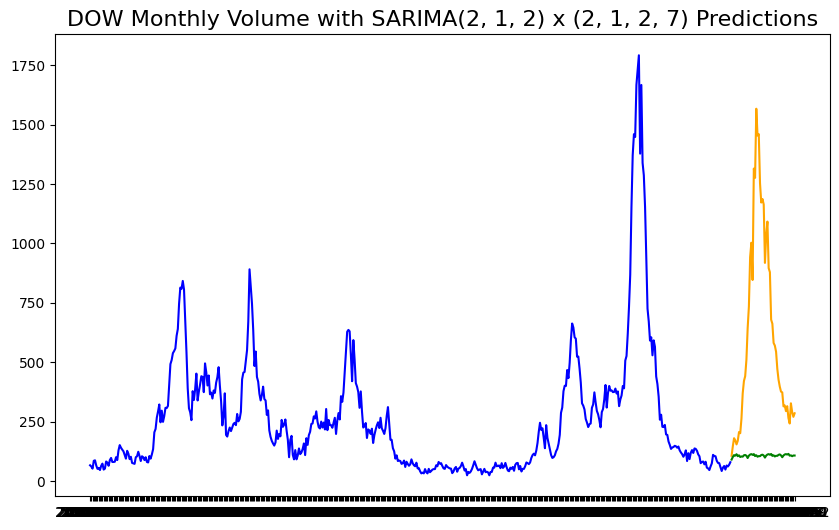

In [44]:
# Fit a SARIMA(1, 0, 0) x (1, 0, 0, 13) model.

sarima = SARIMAX(endog = train['dengue_cases'],
                 order = (2, 1, 2),              # (p, d, q)
                 seasonal_order = (2, 1, 2, 7)) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit(disp=False)

# Generate predictions based on test set.
preds = model.predict(start=len(train_data), 
                              end=len(train_data) + len(test_data) - 1,)

# Evaluate predictions.
#print(mean_squared_error(test['dengue_cases'], preds))

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train['dengue_cases'], color = 'blue')
plt.plot(test['dengue_cases'], color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'DOW Monthly Volume with SARIMA(2, 1, 2) x (2, 1, 2, 7) Predictions', fontsize=16)
plt.show();